In [1]:
import tensorflow as tf
from misc import celeba_img_gen, viz_batch, save_batch, gen_loss, recon_loss, dis_loss

# Create a Data Generator

In [2]:
gen = celeba_img_gen(batch_size=4)
batch1, batch2 = next(gen)
print(batch1.shape, batch2.shape) # check that the shapes are as expected

(4, 192, 160, 3) (4, 192, 160, 3)


# Visualise a Batch of Data (from Each Domain) from the Generator

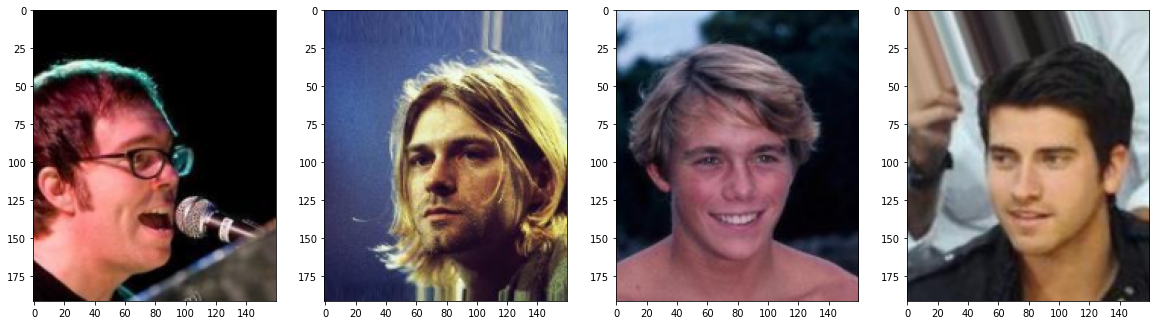

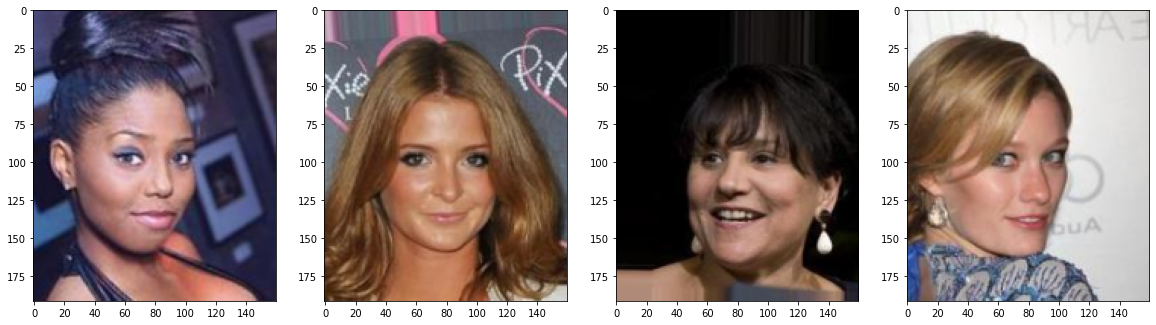

In [3]:
viz_batch(batch1)
viz_batch(batch2)


# Create the Generator Network

In [4]:
tfkl = tf.keras.layers

def build_generator(input_shape):
     """
     The architecture resembles a U-Net without shortcut connections
     """
     input_layer = tf.keras.Input(input_shape)
     # encoder
     t = tfkl.Conv2D(16, 3, padding='same', activation=tf.nn.leaky_relu)(input_layer)
     t = tfkl.Conv2D(16, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.MaxPool2D()(t)
     t = tfkl.Conv2D(32, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(32, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.MaxPool2D()(t)
     t = tfkl.Conv2D(64, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(64, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.MaxPool2D()(t)
     t = tfkl.Conv2D(128, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(128, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.MaxPool2D()(t)
     t = tfkl.Conv2D(256, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(256, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     
     t = tfkl.Conv2D(128, 1, activation=tf.nn.leaky_relu)(t)
     t = tfkl.UpSampling2D()(t)
     t = tfkl.Conv2D(128, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(128, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     # decoder
     t = tfkl.Conv2D(64, 1, activation=tf.nn.leaky_relu)(t)
     t = tfkl.UpSampling2D()(t)
     t = tfkl.Conv2D(64, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(64, 3, padding='same', activation=tf.nn.leaky_relu)(t)

     t = tfkl.Conv2D(32, 1, activation=tf.nn.leaky_relu)(t)
     t = tfkl.UpSampling2D()(t)
     t = tfkl.Conv2D(32, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(32, 3, padding='same', activation=tf.nn.leaky_relu)(t)

     t = tfkl.Conv2D(16, 1, activation=tf.nn.leaky_relu)(t)
     t = tfkl.UpSampling2D()(t)
     t = tfkl.Conv2D(16, 3, padding='same', activation=tf.nn.leaky_relu)(t)
     t = tfkl.Conv2D(16, 3, padding='same', activation=tf.nn.leaky_relu)(t)

     t = tfkl.Conv2D(3, 1, padding='same')(t) # RGB output, activation (if any) to be included in GradientTape
     return tf.keras.Model(inputs=input_layer, outputs=t)

ga = build_generator(batch1.shape[1:]) # generator(A->B)
gb = build_generator(batch1.shape[1:]) # generator(B->A)

In [10]:
ga.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 192, 160, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 192, 160, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 192, 160, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 96, 80, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 80, 32)        4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 96, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 40, 32)        0     

TypeError: expected str, bytes or os.PathLike object, not NoneType

# Make a Discriminator

In [8]:
def discriminator(input_shape):
    '''
    Simple binary classifier
    '''
    input_layer = tfkl.Input(input_shape)
    t = tfkl.Conv2D(16, 3, padding='same', activation=tf.nn.leaky_relu)(input_layer)
    t = tfkl.Conv2D(16, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.MaxPool2D()(t)
    t = tfkl.Conv2D(32, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.Conv2D(32, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.MaxPool2D()(t)
    t = tfkl.Conv2D(64, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.Conv2D(64, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.MaxPool2D()(t)
    t = tfkl.Conv2D(128, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.Conv2D(128, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.MaxPool2D()(t)
    t = tfkl.Conv2D(256, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.Conv2D(256, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.MaxPool2D()(t)
    t = tfkl.Conv2D(512, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.Conv2D(512, 3, padding='same', activation=tf.nn.leaky_relu)(t)
    t = tfkl.Flatten()(t)
    t = tfkl.Dense(512, activation=tf.nn.leaky_relu)(t)
    t = tfkl.Dense(512, activation=tf.nn.leaky_relu)(t)
    t = tfkl.Dense(1)(t)
    return tf.keras.Model(inputs=input_layer, outputs=t)


da = discriminator(batch1.shape[1:]) # Discriminator for Generator(A->B)
db = discriminator(batch1.shape[1:]) # Discriminator for Generator(B->A)

In [9]:
da.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 192, 160, 3)]     0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 192, 160, 16)      448       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 192, 160, 16)      2320      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 96, 80, 16)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 96, 80, 32)        4640      
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 96, 80, 32)        9248      
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 48, 40, 32)        0   

# Training the Models

In [12]:
# Make an optimiser for each model
opt1 = tf.keras.optimizers.Adam(0.0001)
opt2 = tf.keras.optimizers.Adam(0.0001)
opt3 = tf.keras.optimizers.Adam(0.0001)
opt4 = tf.keras.optimizers.Adam(0.0001)

for i in range(1000000): # train indefinately ...
    a_real, b_real = next(gen)

    # normalise data
    # a_real = (a_real / 255).astype('float32')
    # b_real = (b_real / 255).astype('float32')
    a_real = ((a_real - a_real.mean())/a_real.std()).astype('float32')
    b_real = ((b_real - b_real.mean())/b_real.std()).astype('float32')

    # train the generators
    with tf.GradientTape(persistent=True) as tape:
        a_fake = ga(b_real)
        b_fake = gb(a_real)

        a_dis = da(a_fake)
        b_dis = db(b_fake)
        a_gen_loss = gen_loss(a_dis)
        b_gen_loss = gen_loss(b_dis)

        a_recon = ga(b_fake)
        b_recon = gb(a_fake)
        
        a_recon_loss = recon_loss(a_real, a_recon)
        b_recon_loss = recon_loss(b_real, b_recon)

        g_loss = a_gen_loss + b_gen_loss + a_recon_loss + b_recon_loss # sum all the losses

    grad = tape.gradient(g_loss, ga.trainable_variables)
    opt1.apply_gradients(zip(grad, ga.trainable_variables))

    grad = tape.gradient(g_loss, gb.trainable_variables)
    opt2.apply_gradients(zip(grad, gb.trainable_variables))

    # train the discriminators
    with tf.GradientTape(persistent=True) as tape:
        a_fake = ga(b_real)
        b_fake = gb(a_real)

        a_dis_f = da(a_fake)
        d_dis_f = db(b_fake)

        a_dis_r = da(a_real)
        d_dis_r = db(b_real)

        a_dis_loss = dis_loss(a_dis_r, a_dis_f)
        b_dis_loss = dis_loss(d_dis_r, d_dis_f)

    grad = tape.gradient(a_dis_loss, da.trainable_variables)
    opt3.apply_gradients(zip(grad, da.trainable_variables))

    grad = tape.gradient(b_dis_loss, db.trainable_variables)
    opt4.apply_gradients(zip(grad, db.trainable_variables))
    
    print(i, g_loss.numpy(), (a_dis_loss + b_dis_loss).numpy())

    if i % 50 == 0:
        # save some data every 50 steps
        save_batch(a_fake.numpy(), "b-a")
        save_batch(b_fake.numpy(), "a-b")
        save_batch(a_real, "a")
        save_batch(b_real, "b")



    
        



0 3.0171902 0.20264876
1 4.6675916 0.02776761
2 5.1138353 0.051196665
3 3.8855734 0.1029996
4 3.6176543 0.19501454
5 4.104208 0.053477876
6 5.86341 0.60892856
7 4.2902737 0.2109139
8 5.1283045 0.21779075
9 5.1613727 0.09219529
10 4.621531 0.067938626
11 4.3011565 0.024187341
12 3.8262315 0.08284627
13 3.8897169 0.08287063
14 4.054861 0.024454106
15 4.342772 0.010798866
16 4.4197807 0.03043879
17 4.267581 0.02524868
18 3.864925 0.00621481
19 3.5950189 0.041872602
20 3.7870517 0.012164826


KeyboardInterrupt: 